# 11장 의료 영상 AI
- Chest X-RAY 폐렴 분류

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Introduction
In this notebook we will preprocess the data for our classification task.<br />
We will train a classifier to predict whether an X-Ray of a patient shows signs of pneumonia or not based on the RSNA Pneumonia Detection Challenge (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge).

At first we download the data from kaggle (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data), by clicking on "Download All" and extract it afterwards.

Acknowledgements:
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, http://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

## Imports
* pathlib for convenient path handling
* pydicom for reading dicom files
* numpy for storing the actual images
* cv2 for directly resizing the images
* pandas to read the provided labels
* matplotlib for visualizing some images
* tqdm for nice progress bar

In [1]:
!pip install -Uqq pydicom torchmetrics

In [ ]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path
import pydicom
import cv2
from tqdm.notebook import tqdm

## Preprocessing

### Read the csv file containing the labels

In [2]:
root = "/content/drive/MyDrive/AI_application/pn_data_n1000/"
# root = "./pn_data_n1000/"

labels = pd.read_csv(root + "stage_2_train_labels.csv")
print("shape = ", labels.shape)
print(labels.head(6))

shape =  (30227, 6)
                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1


Note that subjects may occur multiple times in the dataset because different pneumonia spots are handled indivually. For our classification task, we can remove those duplicates as we are only interested in the binary label.

In [3]:
# Remove duplicate entries
labels = labels.drop_duplicates("patientId")
print("shape = ", labels.shape)
labels.head()

shape =  (26684, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Let's define the path to the dicom files and also the path were we want to store our processed npy files

In [4]:
ROOT_PATH = Path(root + "stage_2_train_images")
SAVE_PATH = Path(root + "Processed")
print(ROOT_PATH)
print(SAVE_PATH)

pn_data_n1000\stage_2_train_images
pn_data_n1000\Processed


### Chest X-ray images

image list = 
 [WindowsPath('pn_data_n1000/stage_2_train_images/00a85be6-6eb0-421d-8acf-ff2dc0007e8a.dcm'), WindowsPath('pn_data_n1000/stage_2_train_images/00aecb01-a116-45a2-956c-08d2fa55433f.dcm'), WindowsPath('pn_data_n1000/stage_2_train_images/00c0b293-48e7-4e16-ac76-9269ba535a62.dcm'), WindowsPath('pn_data_n1000/stage_2_train_images/00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b.dcm'), WindowsPath('pn_data_n1000/stage_2_train_images/00f08de1-517e-4652-a04f-d1dc9ee48593.dcm'), WindowsPath('pn_data_n1000/stage_2_train_images/00f87de5-5fe0-4921-93ea-914d7e683266.dcm'), WindowsPath('pn_data_n1000/stage_2_train_images/01a4059c-22f7-4f51-8a27-50aff0b3aeb3.dcm'), WindowsPath('pn_data_n1000/stage_2_train_images/01a5594f-e5d4-4f7a-b79d-3f57559fe37b.dcm'), WindowsPath('pn_data_n1000/stage_2_train_images/01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce.dcm')]
target_list = 
 [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1)]


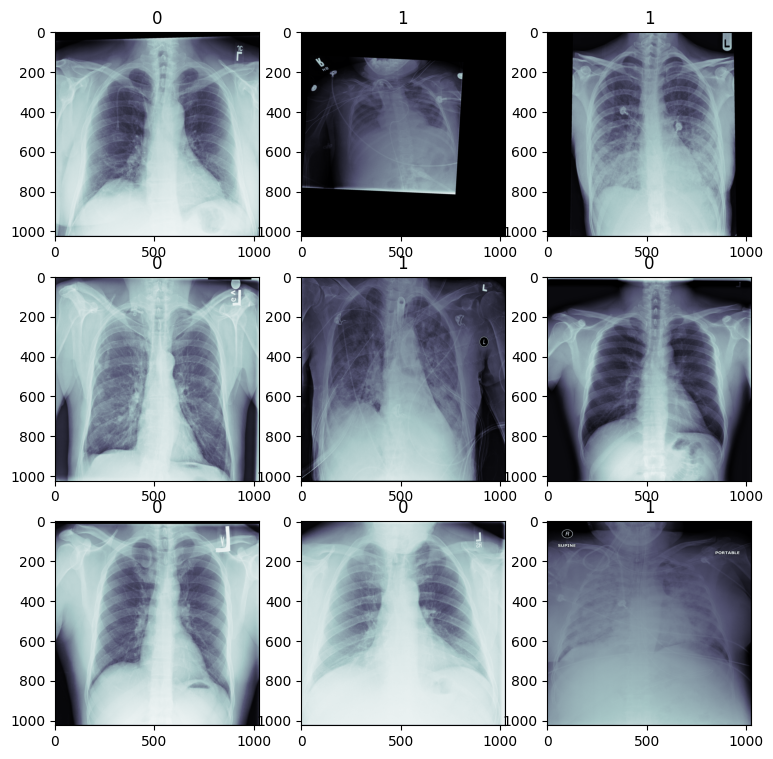

In [5]:
c = 0
image_list = []
target_list = []
while len(image_list) <= 8:
    patient_id = labels.patientId.iloc[c]
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    try:
        dcm = pydicom.dcmread(dcm_path).pixel_array
        image_list.append(dcm_path)
        target_list.append(labels.Target.iloc[c])
        c += 1
    except:
        c +=1
print("image list = \n", image_list)
print("target_list = \n", target_list)


fig, axis = plt.subplots(3, 3, figsize=(9, 9))
for i in range(9):
    row, col = divmod(i, 3)
    dcm = pydicom.dcmread(image_list[i]).pixel_array

    label = target_list[i]

    axis[row, col].imshow(dcm, cmap="bone")
    axis[row, col].set_title(label)

### Dicom Reading & Effective storage

In order to efficiently handle our data in the Dataloader, we convert the X-Ray images stored in the DICOM format to numpy arrays. Afterwards we compute the overall mean and standard deviation of the pixels of the whole dataset, for the purpose of normalization.
Then the created numpy images are stored in two separate folders according to their binary label:
* 0: All X-Rays which do not show signs of pneumonia
* 1: All X-Rays which show signs of pneumonia

To do so, we iterate over the patient ids and concat the patient ID with the ROOT_PATH.

We then directly save the standardized and resized files into the corresponding directory (0 for healthy, 1 for pneumonia).
This allows to take advantage of the ready-to-use torchvision **DatasetFolder** for simple file reading


We standardize all images by the maximum pixel value in the provided dataset, 255.
All images are resized to 224x224.

To compute dataset mean and standard deviation, we compute the sum of the pixel values as well as the sum of the squared pixel values for each subject.
This allows to compute the overall mean and standard deviation without keeping the whole dataset in memory.


In [6]:
ROOT_PATH

WindowsPath('pn_data_n1000/stage_2_train_images')

In [7]:
lentrain = len(os.listdir(ROOT_PATH)) # ROOT_PATH = pn_data_n1000\stage_2_train_images
print("train number = ", lentrain)

lentest = len(os.listdir(root + "/stage_2_test_images/"))
print("test number = ", lentest)

train number =  1000
test number =  100


In [8]:
lentrain = 800

In [9]:
# pip install ipywidgets 
# start vs code again
import os
sums = 0
sums_squared = 0
count = 0
# ipdb.set_trace()
for c, patient_id in enumerate(tqdm(labels.patientId)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

    # if not os.path.isdir(dcm_path):
    #   print("I do not have this file")
    # Read the dicom file with pydicom and standardize the array
    if os.path.exists(dcm_path):
      dcm = pydicom.dcmread(dcm_path).pixel_array / 255

      # Resize the image as 1024x1024 is way to large to be handeled by Deep Learning models at the moment
      # Let's use a shape of 224x224
      # In order to use less space when storing the image we convert it to float16
      dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

      # Retrieve the corresponding label
      label = labels.Target.iloc[c]

      # 4/5 train split, 1/5 val split
      train_or_val = "train" if count < lentrain else "val"

      current_save_path = SAVE_PATH/train_or_val/str(label) # Define save path and create if necessary
      current_save_path.mkdir(parents=True, exist_ok=True)
      np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory

      normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
      # if train_or_val == "train":  # Only use train data to compute dataset statistics
      #     sums += np.sum(dcm_array) / normalizer
      #     sums_squared += (np.power(dcm_array, 2).sum()) / normalizer
      count += 1


  0%|          | 0/26684 [00:00<?, ?it/s]

In [10]:
print(len(os.listdir(root + "Processed/train/0")))
print(len(os.listdir(root + "Processed/train/1")))

print(len(os.listdir(root + "Processed/val/0")))
print(len(os.listdir(root + "Processed/val/1")))

527
273
142
58


In [11]:
SAVE_PATH

WindowsPath('pn_data_n1000/Processed')

In [12]:
for root, dirs, files in os.walk(os.path.join(SAVE_PATH,"train")):
  print(root, dirs, len(files))
print()

for root, dirs, files in os.walk(os.path.join(SAVE_PATH,"val")):
  print(root, dirs, len(files))

pn_data_n1000\Processed\train ['0', '1'] 0
pn_data_n1000\Processed\train\0 [] 527
pn_data_n1000\Processed\train\1 [] 273

pn_data_n1000\Processed\val ['0', '1'] 0
pn_data_n1000\Processed\val\0 [] 142
pn_data_n1000\Processed\val\1 [] 58


### 평균 (Mean) 과 표준 편차 (Std)

In [13]:
os.path.join(SAVE_PATH, "train/**/*.npy")
len(glob.glob(os.path.join(SAVE_PATH, "train/**/*.npy")))

800

In [14]:
sums = 0
sums_squared = 0

for files in tqdm(glob.glob(os.path.join(SAVE_PATH, "train/**/*.npy"))):
  dcm_array = np.load(files)
  # Create the path to the dcm file
  normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
  sums += np.sum(dcm_array) / normalizer
  sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

  0%|          | 0/800 [00:00<?, ?it/s]

In [15]:
mean = sums / lentrain
std = np.sqrt(sums_squared / lentrain - (mean**2))

print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.494384765625, STD: 0.2406005859375


## Training

In [16]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
print(torch.__version__)

cuda:0
2.7.1+cu126


First we create our dataset.
We can leverage the **DatasetFolder** from torchvision: It allows to simply pass a root directory and return return a dataset object with access to all files within the directory and the directory name as class label. <br />
We only need to define a loader function, **load_file**, which defines how the files shall be loaded.
This is very comfortable as we only have to load our previously stored numpy files.
Additionally, we need to define a list of file extensions (just "npy" in our case).

Finally we can pass a transformation sequence for Data Augmentation and Normalization.

We use:
* RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

In [17]:
train_transforms = transforms.Compose([
                            transforms.ToTensor(),  # Convert numpy array to tensor
                            transforms.Normalize(0.097, 0.241),  # Use mean and std from preprocessing notebook
                            transforms.RandomAffine( # Data Augmentation
                                degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                            transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
                            ])

val_transforms = transforms.Compose([
                            transforms.ToTensor(),  # Convert numpy array to tensor
                            transforms.Normalize(0.097, 0.241),  # Use mean and std from preprocessing notebook
                            ])

In [18]:
train_transforms = transforms.Compose([
                            transforms.ToTensor(),  
                            transforms.Normalize(0.097, 0.241),  
                            transforms.RandomAffine(
                            degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                            transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
                            ])

Finally, we create the train and val dataset and the corresponding data loaders.

Please adapt batch size and num_workers according to your hardware ressources.

In [19]:
os.path.join(SAVE_PATH)

'pn_data_n1000\\Processed'

In [20]:
def load_file(path):
    return np.load(path).astype(np.float32)

# PyTorch dataset class that expects a folder structure where each subfolder represents a class.
# More generic than ImageFolder
# Can be used for any dataset type, not just images (e.g., audio, text, numpy files).
# Requires a custom loader function to specify how the data should be read.
# Labels are still inferred from folder names, similar to ImageFolder
os.path.join(SAVE_PATH)
train_dataset = datasets.DatasetFolder(root = os.path.join(SAVE_PATH, "train"),
                                        loader=load_file,
                                        extensions="npy",
                                        transform=train_transforms)

val_dataset = datasets.DatasetFolder(root = os.path.join(SAVE_PATH, "val"),
                                       loader=load_file,
                                       extensions="npy",
                                       transform=val_transforms)


###  Augmented train images

In [21]:
train_dataset

Dataset DatasetFolder
    Number of datapoints: 800
    Root location: pn_data_n1000\Processed\train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.097, std=0.241)
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
               RandomResizedCrop(size=(224, 224), scale=(0.35, 1), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
           )

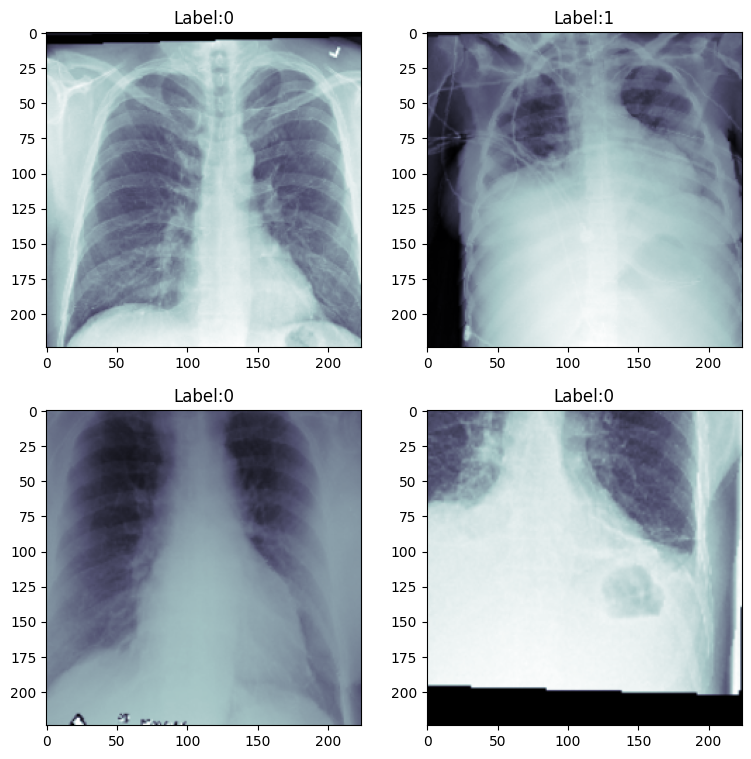

In [22]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 800)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [23]:
batch_size = 64 #TODO
# num_workers = 4#TODO

train_loader = DataLoader(train_dataset,
                        batch_size=batch_size,
                        # num_workers=num_workers,
                        shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        # num_workers=num_workers,
                        # persistent_workers=True,
                        shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")
print(f"There are {len(train_loader)} train batches and {len(val_loader)} val batches")


There are 800 train images and 200 val images
There are 13 train batches and 4 val batches


In [24]:
a, b = next(iter(train_loader))
print(b, ":", b.shape)
print(a.dtype, ":", a.shape)

tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1]) : torch.Size([64])
torch.float32 : torch.Size([64, 1, 224, 224])


The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia.
There are multiple ways to deal with imbalanced datasets:
* Weighted Loss
* Oversampling
* Doing nothing :)

In this example, we will simply do nothing as this often yields the best results.
Buf feel free to play around with a weighted loss. A template to define a customized weighted loss function is provided below.

Oversampling will be shown in a later lecture.

In [25]:
print(np.unique(train_dataset.targets, return_counts=True))
print(np.unique(val_dataset.targets, return_counts=True))
train_dataset[0][0].shape

(array([0, 1]), array([527, 273]))
(array([0, 1]), array([142,  58]))


torch.Size([1, 224, 224])

### Model Creation in pytorch lightning

Each pytorch lightning model is defined by at least an initialization method, a **forward** function which defines the forward pass/prediction, a **training_step** which yields the loss and **configure_optimizers** to specify the optimization algorithm.

Additionally, we can use a **training_epoch_end** callback to compute overall dataset statistics and metrics such as accuracy.

Subsequently, we define the **validation_step**. The validation step performs more or less the same steps as the training step, however, on the validation data. In this case, pytorch lightning doesn't update the weights.
Again, we can use **validation_epoch_end** to compute overall dataset metrics.

No loops or manual weight updates are needed!<br />
Additionally, pl also handles device management.  Just pass the number of GPUS when creating the trainer.

**Now it is time to create the model** - We will use the ResNet18 network architecture.

As most of the torchvision models, the original ResNet expects a three channel input in **conv1**. <br />
However, our X-Ray image data has only one channel.
Thus we need to change the in_channel parameter from 3 to 1.

Additionally, we will change the last fully connected layer to have only one output as we have a binary class label.

### Model import

In [26]:
## check pretrained model

weigths = models.ResNet18_Weights.IMAGENET1K_V1
resnet18 = models.resnet18(weights = weigths)
resnet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\nbumk/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 58.1MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
torch.manual_seed(123)
torch.cuda.manual_seed(123)
class PneumoniaModel(nn.Module):
    def __init__(self):
        super().__init__()

        weigths = models.ResNet18_Weights.IMAGENET1K_V1
        self.model = models.resnet18(weights = weigths)
        for param in self.model.parameters():
            param.requires_grad = False
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = nn.Linear(in_features=512, out_features=1)

        # self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        # self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))


    def forward(self, data): #needs to compute output from the resnet and return prediction
        pred = self.model(data)
        return pred

model = PneumoniaModel().to(device)  # Instanciate the model


In [35]:

class PneumoniaModel(nn.Module):
    def __init__(self):
        super().__init__()

        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.model = models.resnet18(weights = weights)
        for param in self.model.parameters():
            param.requires_grad = False
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, data):
        # We need to capture the output of the last convolutional layer
        # and the output of the global average pooling layer.
        # ResNet's forward pass:
        x = self.model.conv1(data)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        conv_output = self.model.layer4(x) # Last convolutional layer output

        pooled_output = self.model.avgpool(conv_output) # Global Average Pooling
        pooled_output = torch.flatten(pooled_output, 1)
        pred = self.model.fc(pooled_output) # Final fully connected layer

        return pred, conv_output # Return both prediction and conv_output for CAM


### Optimizer and Loss
We use the **Adam** Optimizer with a learning rate of 0.0001 and the **BinaryCrossEntropy** Loss function.<br />
(In fact we use **BCEWithLogitsLoss** which directly accepts the raw unprocessed predicted values and computes the sigmoid activation function before applying Cross Entropy).
Feel free to pass a weight different from 1 to the Pneumonia model in order to use the weighted loss function.

In [36]:
# 학습률
lr = 1e-4
weight = 2
# 손실 함수 정의
# handling class imbalance in binary classification tasks.
# pos_weight를 device에 맞게 이동
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight])).to(device)

#
model = PneumoniaModel().to(device)

# 파라미터 수정 대상을 최종 노드로 제한
optimizer = optim.Adam(model.parameters(), lr=lr)
# step_size = 3
# gamma = 0.3
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [31]:
a, b = next(iter(train_loader))
a = a.to(device)
a.shape
# output_a = model(a)
# output_a.shape
b.shape

torch.Size([64])

In [39]:
# PYTORCH_CUDA_ALLOC_CONF=expandable_segments
# torch.cuda.empty_cache()
# 반복 횟수

num_epochs = 10

# 평가 결과 기록
history = []
acc = 0.0
for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0

    model.train()
    print("training")
    for X, Y in tqdm(train_loader):

        data, target = X.to(device), Y.to(device) # X shape = torch.Size([64, 1, 224, 224]), target shape = torch.Size([64])
        output, conv_output = model(data)
        # output shape = torch.Size([64, 1])
        loss = criterion(output.squeeze(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.where(output.squeeze() < 0.0, 0, 1)
        train_loss += loss.item()
        train_acc += (predicted == target).float().mean().item()

    # scheduler.step()
    avg_loss = train_loss/len(train_loader)
    avg_acc = train_acc/len(train_loader)
    print(f"epoch = {epoch}, avg_train_loss = {avg_loss}, avg_train_acc = {avg_acc}")


    model.eval()
    print("validating")
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
        for X_, Y_ in tqdm(val_loader):
            data_, target_ = X_.to(device), Y_.to(device)
            output_, conv_output = model(data_)
            val_loss = criterion(output_.squeeze(), target_.float())
            predicted_ = torch.where(output_.squeeze() < 0.0, 0, 1)
            val_loss += val_loss.item()
            val_acc += (predicted_ == target_).float().mean().item()

    avg_loss_ = val_loss/len(val_loader)
    avg_acc_ = val_acc/len(val_loader)
    print(f"avg_val_loss = {avg_loss_}, avg_val_acc = {avg_acc_}")

    if acc < avg_acc_:
        acc = avg_acc_
        torch.save(model.state_dict(), f"chest_x_epoch_{num_epochs}.pth") # model.load_state_dict(torch.load('chest_x.pth'))
        print("model saved!")


training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 0, avg_train_loss = 0.9391111914928143, avg_train_acc = 0.6454326923076923
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.6492332220077515, avg_val_acc = 0.48828125
model saved!
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 1, avg_train_loss = 0.8982124328613281, avg_train_acc = 0.5985576923076923
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.7329970598220825, avg_val_acc = 0.52734375
model saved!
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 2, avg_train_loss = 0.8984274726647598, avg_train_acc = 0.5841346153846154
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.7776385545730591, avg_val_acc = 0.4765625
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 3, avg_train_loss = 0.8702976474395165, avg_train_acc = 0.6165865384615384
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.8459870219230652, avg_val_acc = 0.53515625
model saved!
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 4, avg_train_loss = 0.902132355249845, avg_train_acc = 0.5769230769230769
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.9149249792098999, avg_val_acc = 0.51171875
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 5, avg_train_loss = 0.8503172810261066, avg_train_acc = 0.6526442307692307
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.9098974466323853, avg_val_acc = 0.55859375
model saved!
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 6, avg_train_loss = 0.8613917048160846, avg_train_acc = 0.6622596153846154
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.9212250709533691, avg_val_acc = 0.6015625
model saved!
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 7, avg_train_loss = 0.8512082099914551, avg_train_acc = 0.6658653846153846
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.9007120132446289, avg_val_acc = 0.609375
model saved!
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 8, avg_train_loss = 0.8517658389531649, avg_train_acc = 0.6514423076923077
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.8905328512191772, avg_val_acc = 0.578125
training


  0%|          | 0/13 [00:00<?, ?it/s]

epoch = 9, avg_train_loss = 0.8303332603894747, avg_train_acc = 0.671875
validating


  0%|          | 0/4 [00:00<?, ?it/s]

avg_val_loss = 0.8848849534988403, avg_val_acc = 0.60546875


## Class Acvitation Maps (CAM)

The key idea of CAM is to multiply the output of the last convolutional layer (BasicBlock 1 of layer 4) $A_k$ (consisting of k channels) with the parameters $w$ of the subsequent fully connected layer to compute an activation map $M$:
$$ M = \sum_k w_kA_k$$

To do so, we need to access this particular output of the trained resnet18.<br />
Let's recap the resnet architecture:

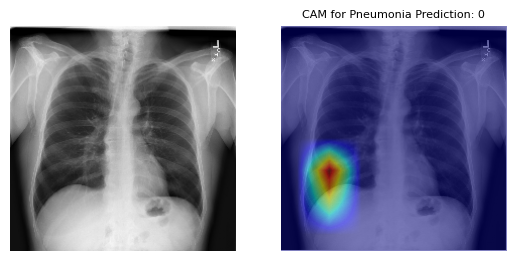

In [103]:
import random

def get_cam(model, input_image, target_class_idx=None):
    """
    Computes Class Activation Map (CAM) for a given model and input image.
    Requires the model to have a Global Average Pooling (GAP) layer
    directly before the final classification layer.

    Args:
        model (nn.Module): The model.
        input_image (torch.Tensor): The input image tensor (1, C, H, W).
        target_class_idx (int, optional): The index of the target class for CAM.
                                          For binary classification with a single output,
                                          this is often implicitly handled by using the
                                          single output neuron's weight.

    Returns:
        np.ndarray: The CAM heatmap.
    """
    model.eval()

    # Get the prediction and the output of the last convolutional layer
    # We modified the forward method to return both
    output, conv_output = model(input_image)

    # For a binary classification model with a single output (like yours)
    # the weights from the final fc layer directly correspond to the importance
    # of each pooled feature for that single output.
    # The weights for the final classification layer (self.model.fc)
    # The shape of model.fc.weight is (out_features, in_features)
    # In your case: (1, 512)
    weights = model.model.fc.weight.data # Get the weights of the fully connected layer

    # If you have a multi-class problem and need to specify a target_class_idx,
    # you would select the corresponding row from `weights`:
    # cam_weights = weights[target_class_idx, :]
    # For a single output (binary classification), you just use the first (and only) row:
    cam_weights = weights[0, :] # This assumes the single output neuron represents the "positive" class

    # Reshape weights to be (1, C, 1, 1) for element-wise multiplication with conv_output
    # conv_output shape: (1, C, H, W) where C=512 for ResNet18 layer4 output
    cam_weights = cam_weights.reshape((1, -1, 1, 1))

    # Perform weighted sum
    # Element-wise multiplication of weights with feature maps, then sum across channels
    cam = (conv_output * cam_weights).sum(dim=1, keepdim=True) # Sum along the channel dimension (dim=1)

    # Apply ReLU
    cam = torch.relu(cam)

    # Normalize to 0-1
    cam = (cam) / (cam.max() + 1e-8) # Add epsilon for numerical stability

    return cam.squeeze(0).squeeze(0).detach().cpu().numpy() # Remove batch and channel dimensions

# 1. Load your trained model
model = PneumoniaModel().to(device)
model.load_state_dict(torch.load('chest_x_epoch_10.pth')) # Load your weights


# 2. Prepare your input image
idx = random.randint(0, len(val_dataset))
image_path = val_dataset[idx][0] # Replace with your image path

input_tensor = image_path.unsqueeze(0).to(device) # Add batch dimension

# 3. Get the CAM heatmap
# For binary classification with a single output, target_class_idx is often not explicitly passed,
# as the single output neuron already represents the class of interest.
heatmap = get_cam(model, input_tensor)

# # 4. Resize heatmap to original image size for overlay
heatmap = cv2.resize(heatmap, (225, 225))

# Display the result
fig, axis = plt.subplots(1, 2)
axis[0].imshow(input_tensor.squeeze().cpu().data, cmap = 'gray')
axis[0].axis('off')
axis[1].imshow(input_tensor.squeeze().cpu().data, cmap = 'gray')
axis[1].imshow(heatmap, alpha=0.5, cmap = 'jet')
axis[1].axis('off')
plt.title(f'CAM for Pneumonia Prediction: {val_dataset[idx][1]}', size = 8)
plt.show()